## Amplitude analysis

In [1]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve as convolve
from scipy.stats import norm, chi2

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


/usr/local/lib/python3.8/dist-packages/tqdm-4.65.0-py3.8.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
include_wls = False

In [13]:
def moving_average(a, n=3, zero_padding = False, const_padding = False):
    if zero_padding:
        ind = np.arange(n-1)
        a = np.insert(a, ind, np.zeros(n-1))
        a = np.roll(a, -int((n-1)/2))
    if const_padding:
        if n%2 != 1:
            ind1 = np.arange((n-1)/2).astype(int)
            ind2 = -np.arange(1,(n-1)/2).astype(int)
            a = np.insert(a, ind1, np.ones(int((n/2)))*a[0])
            a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
        else:
            ind1 = np.arange((n-1)/2).astype(int)
            ind2 = -np.arange(1,(n+1)/2).astype(int)
            a = np.insert(a, ind1, np.ones(int((n-1)/2))*a[0])
            a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
#Returns binning needed to resolve a frequency.
def get_binning(sim, dt, frequency=80*u.Hz): 
    duration = sim.time[-1]-sim.time[0]
    samples = (duration/dt.to(u.s)).value
    return int((1/frequency*samples/duration).value) #binning needed to filter out sinals with f>f_lb_sasi

In [5]:
def get_template(frequency,n_period, binning):
    frequency, binning = frequency.value, binning.to(u.s).value
    duration = 1/frequency * n_period
    x = np.arange(0,duration+binning,binning)
    template = np.sin(frequency*x*2*np.pi)
    return x, template

In [6]:
# Binning of the moving average filter defined by the Nyquist frequency of the SASI modulation
# If the sampling was to be finer the binning could be done finer, however this comes at the expense of lower
# statistics. Therefore we keep the sampling rate at 1 ms.

def get_average_signal(sim, dt, distance, frequency=80*u.Hz):
    binning = get_binning(sim, dt, frequency)

    #detector_signal s0 is not drawn from distribution
    t, s0_i3 = sim.detector_signal(dt=dt, subdetector='i3')
    t, s0_dc = sim.detector_signal(dt=dt, subdetector='dc')
    t, s0_md = sim.detector_signal(dt=dt, subdetector='md')

    s0_ic86 = s0_i3 + s0_dc
    s0_gen2 = s0_i3 + s0_dc + s0_md
    t = t.to(u.ms)

    #averaged signal sa binning size defined by the Nyquist frequency of the SASI modulation and constant padding
    sa_ic86 = moving_average(s0_ic86, n=binning, const_padding=True)
    sa_gen2 = moving_average(s0_gen2, n=binning, const_padding=True)
    
    return sa_gen2, sa_ic86

In [7]:
# Return the critical value of a KS test given an alpha value (1-p value)
def crit_value_from_alpha(alpha):
    return np.sqrt(-np.log(alpha/2)*1/2)

In [8]:
# Return the alpha value (1-p value) given a critical value of a KS test
def alpha_from_crit_value(crit_value):
    return 2*np.exp(-2*crit_value**2)

In [14]:
dt = 0.1*u.ms # highest frequency in Tamborra 2014 model

model = {'name': 'Tamborra_2014',
         'param':{
             'progenitor_mass': 20*u.Msun}
         }
sim = Simulation(model=model,
                 distance=10* u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.006*u.s, tmax=0.338*u.s, dt=dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 geomscope = 'Gen2',
                 include_wls = include_wls)
sim.run()

In [ ]:
for flavor in sim.flavors:
    plt.plot(sim.time, sim.E_per_V[flavor], label=flavor.name)
plt.legend()
ax = plt.gca()
ax.set(xlabel=r't-t$_{bounce}$ [s]', ylabel='Energy Deposition [Mev m$^{-3}$])', xlim=(0.006, 0.338))
ax.grid()

In [15]:
dt = 1 * u.ms
sasi_wind = [140, 300] * u.ms
ana_wind = [160, 275] * u.ms

In [9]:
#average background given by the mean of the sensor distribution and scaled to the full detector
ba_ic86 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu)*dt/(1*u.s)
ba_gen2 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu + sim.detector.n_md*sim.detector.md_bg_mu)*dt/(1*u.s)

In [16]:
def signal_processing(sim, dt, distance, trials, method = None, pearson_binning=100, 
                      return_raw=False,
                      return_deviation=False, 
                      return_percentage=False,
                      return_correlation=False,
                      return_max_correlation=False,
                      return_dist=False,
                      return_alpha=False,
                      return_significance=False):
         
    # scale simulation with distance
    sim.scale_result(distance=distance)
    
    sa_gen2, sa_ic86 = get_average_signal(sim, dt=dt, distance=distance)
    
    # time and signal realization for each detector component
    t, s_i3 = sim.detector_hits(dt=dt, subdetector='i3', size=trials)
    t, s_dc = sim.detector_hits(dt=dt, subdetector='dc', size=trials)
    t, s_md = sim.detector_hits(dt=dt, subdetector='md', size=trials)
    #t, s_ws = sim.detector_hits(dt=dt, subdetector='ws')
    t = t.to(u.ms)

    # random background realization
    b_i3 = sim.detector.i3_bg(dt=dt, size=s_i3.shape[1]*trials)
    b_dc = sim.detector.dc_bg(dt=dt, size=s_dc.shape[1]*trials)
    b_md = sim.detector.md_bg(dt=dt, size=s_md.shape[1]*trials)
    #b_ws = sim.detector.ws_bg(dt=dt, size=len(s_ws)*trials)
    
    # reshape background
    b_i3 = b_i3.reshape(trials,s_i3.shape[1])
    b_dc = b_dc.reshape(trials,s_dc.shape[1])
    b_md = b_md.reshape(trials,s_md.shape[1])

    ### SIGNAL TRIALS ###
    s_ic86 = s_i3 + s_dc
    s_gen2 = s_i3 + s_dc + s_md
    b_ic86 = b_i3 + b_dc
    b_gen2 = b_i3 + b_dc + b_md

    # combined signal S: signal + background
    S_ic86 = s_ic86 + b_ic86
    S_gen2 = s_gen2 + b_gen2

    # background subtraction Sb: signal + background - average background
    Sb_ic86 = S_ic86 - ba_ic86
    Sb_gen2 = S_gen2 - ba_gen2
    
    # deviation Sd: signal + background - average background - average signal
    Sd_ic86 = Sb_ic86 - sa_ic86
    Sd_gen2 = Sb_gen2 - sa_gen2

    # percentage deviation Sp: (signal + background - average background)/average signal
    Sp_ic86 = (Sb_ic86/sa_ic86)-1
    Sp_gen2 = (Sb_gen2/sa_gen2)-1
        
    # analysis window mask
    tmask = np.logical_and(t>=ana_wind[0], t<=ana_wind[1])
    
    # generate template of same shape in dimension 0 as data to convolve with
    t_template, template = get_template(frequency=80*u.Hz, n_period=8, binning=dt)
    template = np.repeat(template,repeats=trials)
    template = template.reshape(trials,-1)

    # cross correlation in analysis window, negative sign applied such that scipy.signal.fftconvolve returns same 
    # sign than np.correlate
    Sc_ic86 = -convolve(Sp_ic86[:,tmask], template, mode='same', axes=-1)
    Sc_gen2 = -convolve(Sp_gen2[:,tmask], template, mode='same', axes=-1)

    # maximum cross correlation
    Sm_ic86 = np.nanmax(Sc_ic86, axis=-1)
    Sm_gen2 = np.nanmax(Sc_gen2, axis=-1)

    ### BACKGROUND TRIALS ###
    # combined signal S: average signal + background
    B_ic86 = sa_ic86 + b_ic86
    B_gen2 = sa_gen2 + b_gen2

    # background subtraction Sb: average signal + background - average background
    Bb_ic86 = B_ic86 - ba_ic86
    Bb_gen2 = B_gen2 - ba_gen2

    # deviation Sd: average signal + background - average background - average signal = background - average background
    Bd_ic86 = b_ic86 - ba_ic86
    Bd_gen2 = b_gen2 - ba_gen2

    # percentage deviation Sp: (average signal + background - average background)/average signal
    Bp_ic86 = (Bb_ic86/sa_ic86)-1
    Bp_gen2 = (Bb_gen2/sa_gen2)-1
    
    # cross correlation in analysis window
    Bc_ic86 = convolve(Bp_ic86[:,tmask], template, mode='same', axes=-1)
    Bc_gen2 = convolve(Bp_gen2[:,tmask], template, mode='same', axes=-1)

    # maximum cross correlation
    Bm_ic86 = np.nanmax(Bc_ic86, axis=-1)
    Bm_gen2 = np.nanmax(Bc_gen2, axis=-1)
    
    ### SIGNIFICANCE ###
    
    if method == 'KS':
    # Method 1: Kolmogorov-Smirnov Test: Histogram Bm and Sm, H_Bm and H_Sm, with binning 
    # m = len(H_Bm) and n = len(H_Sm). Compute the CDF
    
        # computed to get the range of the histogram fixed for all four histograms for a given distance
        comb_data = np.hstack((Sm_ic86, Bm_ic86, Sm_gen2, Bm_gen2))
        rmin, rmax = np.min(comb_data), np.max(comb_data)

        # normalized histogram = PDF
        Spdf_ic86, bins = np.histogram(Sm_ic86, bins = 100, density=True, range = [rmin,rmax])
        Bpdf_ic86, bins = np.histogram(Bm_ic86, bins = 100, density=True, range = [rmin,rmax])
        Spdf_gen2, bins = np.histogram(Sm_gen2, bins = 100, density=True, range = [rmin,rmax])
        Bpdf_gen2, bins = np.histogram(Bm_gen2, bins = 100, density=True, range = [rmin,rmax])

        # histgram x values
        x = (bins[1:]+bins[:-1])/2

        # number of samples (binning of histogram)
        n_ic86 = len(Bpdf_ic86)
        m_ic86 = len(Spdf_ic86)
        n_gen2 = len(Bpdf_gen2)
        m_gen2 = len(Spdf_gen2)

        mn_ic86 = (m_ic86+n_ic86)/(m_ic86*n_ic86)
        mn_gen2 = (m_gen2+n_gen2)/(m_gen2*n_gen2)

        # cumulated histogram = CDF
        Scdf_gen2 = np.cumsum(Spdf_gen2)/np.sum(Spdf_gen2)
        Bcdf_gen2 = np.cumsum(Bpdf_gen2)/np.sum(Bpdf_gen2)
        Scdf_ic86 = np.cumsum(Spdf_ic86)/np.sum(Spdf_ic86)
        Bcdf_ic86 = np.cumsum(Bpdf_ic86)/np.sum(Bpdf_ic86)

        # largest difference between the signal and background CDF
        D_ic86 = np.max(np.abs(Bcdf_ic86- Scdf_ic86))
        D_gen2 = np.max(np.abs(Bcdf_gen2- Scdf_gen2))

        # critical value
        cv_ic86 = D_ic86 * np.sqrt(1/mn_ic86)
        cv_gen2 = D_gen2 * np.sqrt(1/mn_gen2)

        # alpha corresponding to critial value (alpha = 1 - p-value)
        alpha_ic86 = alpha_from_crit_value(cv_ic86)
        alpha_gen2 = alpha_from_crit_value(cv_gen2)

        # two-sided Z score corresponding to the respective p-value (1-alpha)
        Z_ic86 = norm.ppf((1+alpha_ic86)/2)
        Z_gen2 = norm.ppf((1+alpha_gen2)/2)
    
    if method == 'Pearson':
    #Method 2: Pearson Chi2 Test: Compute chi-square and get p-value from chi2 distribution. For the chi2 we use a
    #un-normalized histogram
        
        # computed to get the range of the histogram fixed for all four histograms for a given distance
        comb_data = np.hstack((Sm_ic86, Bm_ic86, Sm_gen2, Bm_gen2))
        rmin, rmax = np.min(comb_data), np.max(comb_data)

        # histogram
        Sh_ic86, bins = np.histogram(Sm_ic86, bins = pearson_binning, density=True, range = [rmin,rmax])
        Bh_ic86, bins = np.histogram(Bm_ic86, bins = pearson_binning, density=True, range = [rmin,rmax])
        Sh_gen2, bins = np.histogram(Sm_gen2, bins = pearson_binning, density=True, range = [rmin,rmax])
        Bh_gen2, bins = np.histogram(Bm_gen2, bins = pearson_binning, density=True, range = [rmin,rmax])
        
        # histgram x values
        x = (bins[1:]+bins[:-1])/2
        
        # check if count is greater than min count
        min_count = 0
        MS_ic86 = Sh_ic86 > min_count
        MB_ic86 = Bh_ic86 > min_count
        MS_gen2 = Sh_gen2 > min_count
        MB_gen2 = Bh_gen2 > min_count
        
        # combine signal and background masks (we need the requirement 
        # count > min_count to hold true in each distribution)
        M_ic86 = np.logical_and(MS_ic86, MB_ic86)
        M_gen2 = np.logical_and(MS_gen2, MB_gen2)

        # compute the chi2 between the background and signal distribution in the 
        chi2_ic86 = np.sum((Sh_ic86[M_ic86]-Bh_ic86[M_ic86])**2/Bh_ic86[M_ic86])
        chi2_gen2 = np.sum((Sh_gen2[M_gen2]-Bh_gen2[M_gen2])**2/Bh_gen2[M_gen2])
        
        # cumulated chi2 distribution at position of the above chi2 = alpha = 1-p-value
        alpha_ic86 = chi2.cdf(chi2_ic86, df = pearson_binning)
        alpha_gen2 = chi2.cdf(chi2_gen2, df = pearson_binning)
        
        # two-sided Z score corresponding to the respective p-value (1-alpha)
        Z_ic86 = norm.ppf((1+alpha_ic86)/2)
        Z_gen2 = norm.ppf((1+alpha_gen2)/2)

    
    if return_raw:
        return t, s_gen2, sa_gen2, b_gen2, s_ic86, sa_ic86, b_ic86
    
    if return_deviation:
        return t, Sd_gen2, Sd_ic86, Bd_gen2, Bd_ic86
    
    if return_percentage:
        return t, Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86
    
    if return_correlation:
        return t[tmask], Sc_gen2, Sc_ic86, Bc_gen2, Bc_ic86
    
    if return_max_correlation:
        return t, Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86
    
    if method == 'KS' and return_dist:
        return x, Spdf_gen2, Bpdf_gen2, Spdf_ic86, Bpdf_ic86, Scdf_gen2, Bcdf_gen2, Scdf_ic86, Bcdf_ic86
    
    if method == 'Pearson' and return_dist:
        return x[M_gen2], Sh_gen2[M_gen2], Bh_gen2[M_gen2], x[M_ic86], Sh_ic86[M_ic86], Bh_ic86[M_ic86]
    
    if method == 'KS' and return_alpha:
        return D_gen2, D_ic86, cv_gen2, cv_ic86, alpha_gen2, alpha_ic86
    
    if method == 'Pearson' and return_alpha:
        return chi2_gen2, chi2_ic86, alpha_gen2, alpha_ic86
    
    if return_significance:
        return Z_gen2, Z_ic86

In [ ]:
t, s_gen2, sa_gen2, b_gen2, s_ic86, sa_ic86, b_ic86 = signal_processing(sim, dt=dt, distance=5*u.kpc, trials=10000, return_raw=True)

fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].step(t,s_gen2[0], color = 'C0', ls = '-', label=r'S$_{Gen2}$')
ax[0].step(t,sa_gen2, color = 'blue', ls = '--', label=r'$\overline{S}_{Gen2}$')
ax[0].step(t,b_gen2[0], color = 'C0', ls = ':', label=r'B$_{Gen2}$')
ax[0].axhline(ba_gen2, color = 'blue', ls = '-.', label=r'$\overline{B}_{Gen2}$')
ax[1].step(t,s_ic86[0], color = 'C1', ls = '-', label=r'S$_{IC86}$')
ax[1].step(t,sa_ic86, color = 'orange', ls = '--', label=r'$\overline{S}_{IC86}$')
ax[1].step(t,b_ic86[0], color = 'C1', ls = ':', label=r'B$_{Gen2}$')
ax[1].axhline(ba_ic86, color = 'orange', ls = '-.', label=r'$\overline{B}_{IC86}$')
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('Counts/bin')
ax[0].set_xlim(0,350)
ax[0].legend(loc = 'upper left')
ax[1].set_xlabel('Time [ms]')
ax[1].set_ylabel('Counts/bin')
ax[1].set_xlim(0,350)
ax[1].legend(loc = 'upper left')
plt.tight_layout()

In [17]:
t, s_gen2, sa_gen2, b_gen2, s_ic86, sa_ic86, b_ic86 = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=10000, return_raw=True)

In [11]:
t, s_wls, sa_wls, b_wls, s_ic86, sa_ic86, b_ic86 = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=10000, return_raw=True)

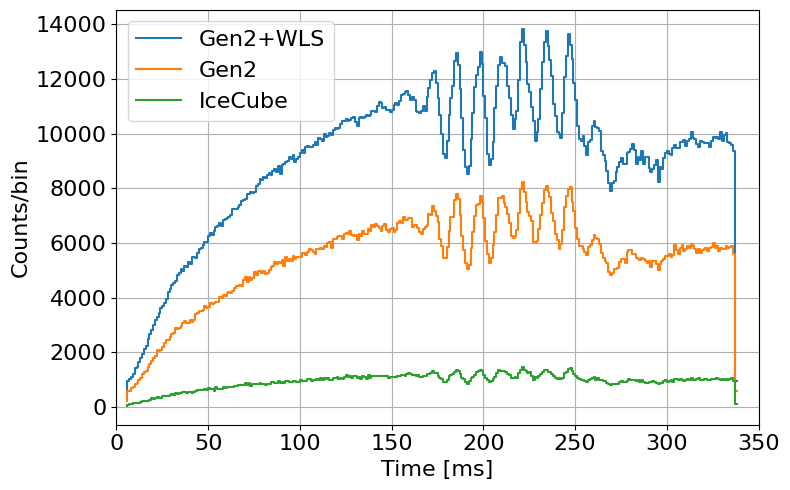

In [18]:
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.step(t,s_wls[0], color = 'C0', ls = '-', label='Gen2+WLS')
ax.step(t,s_gen2[0], color = 'C1', ls = '-', label='Gen2')
ax.step(t,s_ic86[0], color = 'C2', ls = '-', label='IceCube')
ax.set_xlabel('Time [ms]', fontsize=16)
ax.set_ylabel('Counts/bin', fontsize=16)
ax.set_xlim(0,350)
ax.grid()
ax.tick_params(labelsize=16)
ax.legend(loc = 'upper left', fontsize=16)
plt.tight_layout()

In [ ]:
t, Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86 = signal_processing(sim, dt=dt, distance=5*u.kpc, trials=10, return_percentage=True)
tt, ty = get_template(frequency=80*u.Hz, n_period=8, binning=dt)
tt = tt * u.s.to(u.ms)+170
ty /= 10
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].step(t,Sp_gen2[0], color = 'C0', ls = '-', label=r'$(S+B-\overline{B})/\overline{S}\mid_{Gen2}$')
ax[0].step(t,Bp_gen2[0], color = 'C0', ls = ':', label=r'$(\overline{S}+B-\overline{B})/\overline{S}\mid_{Gen2}$')
ax[0].plot(tt,ty, color='red', label='template')
ax[1].step(t,Sp_ic86[0], color = 'C1', ls = '-', label=r'$(S+B-\overline{B})/\overline{S}\mid_{IC86}$')
ax[1].step(t,Bp_ic86[0], color = 'C1', ls = ':', label=r'$(\overline{S}+B-\overline{B})/\overline{S}\mid_{IC86}$')
ax[1].plot(tt,ty, color='black', label='template')
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('Counts/bin')
ax[0].set_xlim(0,350)
ax[0].set_ylim(-0.5,0.5)
ax[0].legend(loc = 'upper left')
ax[1].set_xlabel('Time [ms]')
ax[1].set_ylabel('Counts/bin')
ax[1].set_xlim(0,350)
ax[1].set_ylim(-0.5,0.5)
ax[1].legend(loc = 'upper left')
plt.tight_layout()

In [ ]:
t, Sc_gen2, Sc_ic86, Bc_gen2, Bc_ic86 = signal_processing(sim, dt=dt, distance=3*u.kpc, trials=10, return_correlation=True)

fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].step(t,Sc_gen2[0], color = 'C0', ls = '-', label=r'$CC(T_S)\mid_{Gen2}$')
ax[0].step(t,Bc_gen2[0], color = 'C0', ls = ':', label=r'$CC(T_B)\mid_{Gen2}$')
ax[1].step(t,Sc_ic86[0], color = 'C1', ls = '-', label=r'$CC(T_S)\mid_{IC86}$')
ax[1].step(t,Bc_ic86[0], color = 'C1', ls = ':', label=r'$CC(T_B)\mid_{IC86}$')
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('Cross Correlation')
ax[0].set_xlim(160,275)
ax[0].set_ylim(-1,1)
ax[0].legend(loc = 'upper left')
ax[1].set_xlabel('Time [ms]')
ax[1].set_ylabel('Cross Correlation')
ax[1].set_xlim(160,275)
ax[1].set_ylim(-1,1)
ax[1].legend(loc = 'upper left')
plt.tight_layout()

In [ ]:
x, Spdf_gen2, Bpdf_gen2, Spdf_ic86, Bpdf_ic86, Scdf_gen2, Bcdf_gen2, Scdf_ic86, Bcdf_ic86 = signal_processing(
    sim, dt=dt, distance=10*u.kpc, trials=10000, method='KS', return_dist=True)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].step(x, Spdf_gen2, color = 'C0', ls = '-', label=r'T$_{S,Gen2}$')
ax[0].step(x, Bpdf_gen2, color = 'C0', ls = '--', label=r'T$_{B,Gen2}$')
ax[0].step(x, Spdf_ic86, color = 'C1', ls = '-', label=r'T$_{S,IC86}$')
ax[0].step(x, Bpdf_ic86, color = 'C1', ls = '--', label=r'T$_{B,IC86}$')
ax[0].set_xlabel('max. correlation in SASI period [AU]')
ax[0].set_ylabel('pdf')
ax[0].legend()
ax[1].step(x, Scdf_gen2, color = 'C0', ls = '-', label=r'T$_{S,Gen2}$')
ax[1].step(x, Bcdf_gen2, color = 'C0', ls = '--', label=r'T$_{B,Gen2}$')
ax[1].step(x, Scdf_ic86, color = 'C1', ls = '-', label=r'T$_{S,IC86}$')
ax[1].step(x, Bcdf_ic86, color = 'C1', ls = '--', label=r'T$_{B,IC86}$')
ax[1].set_xlabel('max. correlation in SASI period [AU]')
ax[1].set_ylabel('cdf')
ax[1].legend()
plt.tight_layout()

In [ ]:
dist = 1*u.kpc
D_gen2, D_ic86, cv_gen2, cv_ic86, alpha_gen2, alpha_ic86 = signal_processing(sim, dt=dt, distance=dist, trials=10000,
                                                                             method = 'KS', return_alpha=True)
Z_gen2, Z_ic86 = signal_processing(sim, dt=dt, distance=dist, trials=10000, method = 'KS', return_significance=True)
print('Kolmogorov-Smirnov Test')
print('Gen2, distance {:.0f}: max. CDF difference: {:.3f}, corresponding alpha (1-p): {:.2e}, significance: {:.2f}'.format(dist, D_gen2, alpha_gen2, Z_gen2))
print('IC86, distance {:.0f}: max. CDF difference: {:.3f}, corresponding alpha (1-p): {:.2e}, significance: {:.2f}'.format(dist, D_ic86, alpha_ic86, Z_ic86))

In [ ]:
distances = np.arange(1,21,2) * u.kpc
trials = 10000
Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86, Z_gen2, Z_ic86 = [], [], [], [], [], []
for d in distances:
    print('distance {:.1f}'.format(d))
    z_gen2, z_ic86 =  signal_processing(sim, dt=dt, distance=d, trials=trials, method = 'KS', return_significance=True)
    Z_gen2.append(z_gen2)
    Z_ic86.append(z_ic86)
    
Z_gen2 = np.array(Z_gen2)
Z_ic86 = np.array(Z_ic86)

In [ ]:
fig, ax = plt.subplots(1,1)

ax.plot(distances, Z_gen2, color = 'C0', label=r'$\zeta_{Gen2}$')
ax.plot(distances, Z_ic86, color = 'C1', label=r'$\zeta_{IC86}$')
ax.axhline(3, color='k', ls = ':', label = '3$\sigma$')
ax.set_xlabel('Distance d [kpc]')
ax.set_ylabel('significance $\zeta$')
#ax[1].set_xlim((0,20))
#ax[1].set_xscale('log')
ax.set_yscale('log')
ax.legend()
if include_wls:
    plt.savefig('results_template_KS_IC86+Gen2+WLS_{:.0E}_trials.png'.format(trials))
else:
    plt.savefig('results_template_KS_IC86+Gen2_{:.0E}_trials.png'.format(trials))

plt.tight_layout()

In [ ]:
import pickle
data = [distances, Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86, Z_gen2, Z_ic86]
if include_wls:
    file = open('results_template_KS_IC86+Gen2+WLS_{:.0E}_trials.pkl'.format(trials), 'wb')
else:
    file = open('results_template_KS_IC86+Gen2_{:.0E}_trials.pkl'.format(trials), 'wb')
pickle.dump(data,file)

In [ ]:
x_gen2, Sh_gen2, Bh_gen2, x_ic86, Sh_ic86, Bh_ic86 = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=10000, 
                                                     pearson_binning=100, method='Pearson', return_dist=True)

fig, ax = plt.subplots(1,1)
ax.step(x_gen2, Sh_gen2, color = 'C0', ls = '-', label=r'T$_{S,Gen2}$')
ax.step(x_gen2, Bh_gen2, color = 'C0', ls = '--', label=r'T$_{B,Gen2}$')
ax.step(x_ic86, Sh_ic86, color = 'C1', ls = '-', label=r'T$_{S,IC86}$')
ax.step(x_ic86, Bh_ic86, color = 'C1', ls = '--', label=r'T$_{B,IC86}$')
ax.set_xlabel('max. correlation in SASI period [AU]')
ax.set_ylabel('events')
ax.legend()
plt.tight_layout()

In [ ]:
dist = 6*u.kpc
bins = 100
trials = 10000
chi2_gen2, chi2_ic86, alpha_gen2, alpha_ic86 = signal_processing(sim, dt=dt, distance=dist, trials=trials, 
                                               pearson_binning=bins, method = 'Pearson', return_alpha=True)
Z_gen2, Z_ic86 = signal_processing(sim, dt=dt, distance=dist, trials=trials, pearson_binning=bins, 
                                   method = 'Pearson', return_significance=True)
print('Pearson Test')
print('Gen2, distance {:.0f}: chi2: {:.3f}, chi2/ndof: {:.3f}, alpha (1-p): {:.2e}, significance: {:.2f}'.format(dist, chi2_gen2, chi2_gen2/bins, alpha_gen2, Z_gen2))
print('IC86, distance {:.0f}: chi2: {:.3f}, chi2/ndof: {:.3f}, alpha (1-p): {:.2e}, significance: {:.2f}'.format(dist, chi2_ic86, chi2_ic86/bins, alpha_ic86, Z_ic86))

In [ ]:
alpha_gen2

In [ ]:
distances = np.arange(20,100,10) * u.kpc
trials = 100000
Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86, Z_gen2, Z_ic86 = [], [], [], [], [], []
for d in distances:
    print('distance {:.1f}'.format(d))
    z_gen2, z_ic86 =  signal_processing(sim, dt=dt, distance=d, trials=trials, method = 'Pearson', return_significance=True)
    Z_gen2.append(z_gen2)
    Z_ic86.append(z_ic86)
    
Z_gen2 = np.array(Z_gen2)
Z_ic86 = np.array(Z_ic86)

In [ ]:
fig, ax = plt.subplots(1,1)

ax.plot(distances, Z_gen2, color = 'C0', label=r'$\zeta_{Gen2}$')
ax.plot(distances, Z_ic86, color = 'C1', label=r'$\zeta_{IC86}$')
ax.axhline(3, color='k', ls = ':', label = '3$\sigma$')
ax.set_xlabel('Distance d [kpc]')
ax.set_ylabel('significance $\zeta$')
#ax[1].set_xlim((0,20))
#ax[1].set_xscale('log')
ax.set_yscale('log')
ax.legend()
if include_wls:
    plt.savefig('results_template_Pearson_IC86+Gen2+WLS_{:.0E}_trials.png'.format(trials))
else:
    plt.savefig('results_template_Pearson_IC86+Gen2_{:.0E}_trials.png'.format(trials))

plt.tight_layout()

In [ ]:
Z_gen2, Z_ic86

In [ ]:
from scipy.stats import chi2

In [ ]:
c = chi2.cdf(134, 100)

In [ ]:
norm.ppf((1+0.9999997835470299)/2)